# NNDL Project - Group AHSN

Done By: Aparna , Hannah , Safeyah

## Code Logistics

In [ ]:
# Import modules
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import datasets, layers, models
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation , DepthwiseConv2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D,  GlobalAveragePooling2D, AveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
print('tensorflow version:', tf. __version__)


tensorflow version: 2.9.2


##Load Data

In [ ]:
# code to get data and unzip - works on colab
## Download the dataset and unzip it 
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2022-12-17 00:47:34--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  15.9MB/s    in 65s     

2022-12-17 00:48:39 (3.64 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
# only for use in google colab - allow colab access to your drive for data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# current structure
#ls

In [ ]:
# unzip data file 
!unzip -qq 'tiny-imagenet-200.zip'
!ls

replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
drive  sample_data  tiny-imagenet-200  tiny-imagenet-200.zip


In [ ]:
val_dataframe = pd.read_csv('tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_dataframe.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_dataframe.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [ ]:
train_datagenerator = ImageDataGenerator(rescale=1/255, validation_split=0.2, rotation_range=20,
                        shear_range=0.2, zoom_range=0.09, horizontal_flip=True, fill_mode="nearest")
val_datagenerator = ImageDataGenerator(rescale=1/255)

# https://discuss.codingblocks.com/t/trouble-in-training-the-tiny-imagenet-200-dataset/58979/3
# a. Generally the value for rotation_range is between 10-30.
# b. width_shift_range and height_shift_range have always lead to overfitting for me , try smaller values if you want to try them.
# c. use zoom range between 0.05-0.2 , as increasing it sometime leads to leaving some useful information which might be present in corners of image.
    #validation_split=0.2)
# , zoom_range = 0.1,
#           width_shift_range = 0.2, 
#           height_shift_range = 0.2,
#           horizontal_flip = True,)

train_data = train_datagenerator.flow_from_directory(r'./tiny-imagenet-200/train/', 
                                                     target_size=(224, 224), color_mode='rgb', 
                                                     batch_size=64, class_mode='categorical', 
                                                     shuffle=True, subset='training')

validation_data = train_datagenerator.flow_from_directory(r'./tiny-imagenet-200/train', 
                                                     target_size=(224, 224), color_mode='rgb', 
                                                     batch_size=64, class_mode='categorical', 
                                                     shuffle=True, subset='validation')

Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.


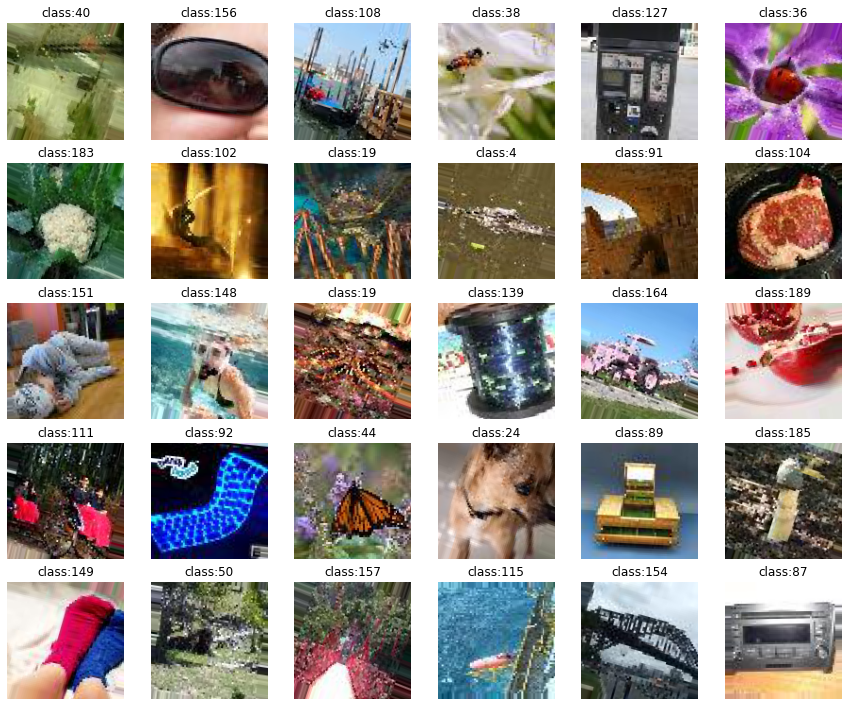

In [ ]:
# plot some images to explore the data - each image is labeled by class
x_batch, y_batch = next(train_data)

plt.figure(figsize=(15, 15))

for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.title('class:' + str(np.argmax(y_batch[i])))
    plt.imshow(x_batch[i,:,:])
    plt.axis("off")

In [ ]:
num_classes = train_data[0][1].shape[1]

print('Number of classes: ', num_classes)

batch_dim = train_data[0][0].shape

print('Batch Size: ', batch_dim[0])
print('Image dimensions: ', batch_dim[1:3])
print('Num Channels Size: ', batch_dim[3])

Number of classes:  200
Batch Size:  64
Image dimensions:  (224, 224)
Num Channels Size:  3


## MobileNet Model

In [ ]:
def create_MobileNet_model(input_shape, no_classes):
    
    print('layer 1 input', input_shape)

    #first layer (Conv/s2)
    input = Input(shape= input_shape)
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2) ,padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    print('layer 2 input', x.shape)
    #second layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(64,(1, 1), (1, 1) ,x)

    print('layer 3 input', x.shape)
    #third layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(128,(1, 1), (1, 1) ,x)
    
    
    print('layer 4 input', x.shape)
    #4th layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(128,(1, 1), (1, 1) ,x)

    print('layer 5 input', x.shape)
    #5th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(256,(1, 1), (1, 1) ,x)

    print('layer 6 input', x.shape)
    #6th layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(256,(1, 1), (1, 1) ,x)

    print('layer 7 input', x.shape)
    #7th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(512,(1, 1), (1, 1) ,x)

    print('layer 8 stack input', x.shape)
    #8thlayer: 5 * (Conv dw/s1) + (Conv dw /s1)
    #for _ in range(5):
    #  x = DepthWiseConv((3,3), (1,1), x)
    #  x = PointWiseConv(512,(1, 1), (1, 1) ,x)

    print('layer 9 input', x.shape)
    #9th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(1024,(1, 1), (1, 1) ,x)

    print('layer 10 input', x.shape)
    #10th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(1024,(1, 1), (1, 1) ,x)

    #x = Dropout(0.2)(x)

    print('Avg Pooling input', x.shape)
    #11th layer: Avg Pooling (7*7)
    x = GlobalAveragePooling2D()(x)

    print('Flatten input', x.shape)
    #print('Flatten layer input', x.shape)
    #Flatten layer / s1? 
    x = Flatten()(x)

    print('Dense 12 input', x.shape)
    #12th layer : Affine layer
    #x = Dense(128,activation='relu')(x)
    out = Dense(no_classes,activation='softmax')(x)

    print('out', out.shape)

    model = Model(input, out, name='mobilenet')

    return model    

In [ ]:
def DepthWiseConv(kernal_size, stride, x):
    result = DepthwiseConv2D(kernal_size, strides=stride , padding='same')(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

In [ ]:
def PointWiseConv(filters,kernal_size, stride, x):
    result = Conv2D(filters, kernel_size=kernal_size, strides=stride)(x)
    result = BatchNormalization()(result)
    result = Activation('relu')(result)
    return result

In [ ]:
MobileNet = create_MobileNet_model((224,224,3),200)
MobileNet.summary()


layer 1 input (224, 224, 3)
layer 2 input (None, 112, 112, 32)
layer 3 input (None, 112, 112, 64)
layer 4 input (None, 56, 56, 128)
layer 5 input (None, 56, 56, 128)
layer 6 input (None, 28, 28, 256)
layer 7 input (None, 28, 28, 256)
layer 8 stack input (None, 14, 14, 512)
layer 9 input (None, 14, 14, 512)
layer 10 input (None, 7, 7, 1024)
Avg Pooling input (None, 7, 7, 1024)
Flatten input (None, 1024)
Dense 12 input (None, 1024)
out (None, 200)
Model: "mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      864       
                                                                 
 batch_normalization_17 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
   

**Accuracy**

In [ ]:
MobileNet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#MobileNet.fit(train_data, epochs=15, validation_data=validation_data, verbose=1)
history = MobileNet.fit(train_data, validation_data = validation_data, epochs = 15)


Epoch 1/15
1250/1250 [==============================] - 1098s 876ms/step - loss: 4.2305 - accuracy: 0.1132 - val_loss: 4.5127 - val_accuracy: 0.1157
Epoch 2/15
1250/1250 [==============================] - 1085s 868ms/step - loss: 3.3279 - accuracy: 0.2440 - val_loss: 3.5977 - val_accuracy: 0.2266
Epoch 3/15
1250/1250 [==============================] - 1094s 875ms/step - loss: 2.9045 - accuracy: 0.3204 - val_loss: 3.2772 - val_accuracy: 0.2655
Epoch 4/15
1250/1250 [==============================] - 1085s 868ms/step - loss: 2.6222 - accuracy: 0.3741 - val_loss: 3.2444 - val_accuracy: 0.2867
Epoch 5/15
1250/1250 [==============================] - 1080s 864ms/step - loss: 2.4076 - accuracy: 0.4179 - val_loss: 2.7981 - val_accuracy: 0.3522
Epoch 6/15
1250/1250 [==============================] - 1087s 870ms/step - loss: 2.2278 - accuracy: 0.4534 - val_loss: 2.6237 - val_accuracy: 0.3886
Epoch 7/15
1250/1250 [==============================] - 1086s 869ms/step - loss: 2.0813 - accuracy: 0.4870

In [ ]:
MobileNet.save(filepath = "./MobileNetv1res224")

## CNN Model

In [ ]:
def create_CNN_model(input_shape, no_classes):
    
    print('layer 1 input', input_shape)

    #first layer (Conv/s2)
    input = Input(shape= input_shape)
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2) ,padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    print('layer 2 input', x.shape)
    #second layer (Conv dw/s1) + (Conv /s1)
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(64,(3,3),(1,1),x)(x)

    print('layer 3 input', x.shape)
    #third layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(128, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(128,(3,3), (2,2),x)(x)  
    
    print('layer 4 input', x.shape)
    #4th layer (Conv dw/s1) + (Conv /s1)
    x = Conv2D(128, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(128,(3,3), (1,1),x)(x)

    print('layer 5 input', x.shape)
    #5th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(256, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(256,(3,3), (2,2),x)(x)

    print('layer 6 input', x.shape)
    #6th layer (Conv dw/s1) + (Conv /s1)
    x = Conv2D(256, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(256,(3,3), (1,1),x)(x)

    print('layer 7 input', x.shape)
    #7th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(512, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(512,(3,3), (2,2),x)(x)

    print('layer 8 stack input', x.shape)
    #8thlayer: 5 * (Conv dw/s1) + (Conv dw /s1)
    for _ in range(5):
      x = Conv2D(512, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      #x = standard_Conv(512,(3,3), (1,1),x)(x)
      
    print('layer 9 input', x.shape)
    #9th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(1024, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(1024,(3,3), (2,2),x)(x)

    print('layer 10 input', x.shape)
    #10th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(1024, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(1024,(3,3), (1,1),x)(x)

    print('Avg Pooling input', x.shape)
    #11th layer: Avg Pooling (7*7)
    x = AveragePooling2D(pool_size=(7,7), strides=(1,1))(x)

    print('Flatten input', x.shape)
    #print('Flatten layer input', x.shape)
    #Flatten layer / s1? 
    x = Flatten()(x)

    print('Dense 12 input', x.shape)
    #12th layer : Affine layer
    out = Dense(no_classes,activation='softmax')(x)

    print('out', out.shape)

    model = Model(input, out, name='CNN')

    return model    

In [ ]:
def standard_Conv(filter,kernal_size, stride, x):
  x = Conv2D(filter, kernel_size=kernal_size, strides=stride ,padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

**Paramaters Count**

In [ ]:
CNN_Model = create_CNN_model((224,224,3),200)
CNN_Model.summary()


layer 1 input (224, 224, 3)
layer 2 input (None, 112, 112, 32)
layer 3 input (None, 112, 112, 64)
layer 4 input (None, 56, 56, 128)
layer 5 input (None, 56, 56, 128)
layer 6 input (None, 28, 28, 256)
layer 7 input (None, 28, 28, 256)
layer 8 stack input (None, 14, 14, 512)
layer 9 input (None, 14, 14, 512)
layer 10 input (None, 7, 7, 1024)
Avg Pooling input (None, 7, 7, 1024)
Flatten input (None, 1, 1, 1024)
Dense 12 input (None, 1024)
out (None, 200)
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 32)      864       
                                                                 
 batch_normalization_27 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
   

**Accuarcy**

In [ ]:
CNN_Model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
CNN_Model.fit(train_data, epochs=15, validation_data=validation_generator, verbose=1)

Epoch 1/15
391/391 [==============================] - 651s 2s/step - loss: 4.7882 - accuracy: 0.0422 - val_loss: 5.0270 - val_accuracy: 0.0358
Epoch 2/15
391/391 [==============================] - 620s 2s/step - loss: 4.1197 - accuracy: 0.1081 - val_loss: 4.4684 - val_accuracy: 0.0832
Epoch 3/15
391/391 [==============================] - 621s 2s/step - loss: 3.6479 - accuracy: 0.1783 - val_loss: 3.9899 - val_accuracy: 0.1480
Epoch 4/15
382/391 [============================>.] - ETA: 13s - loss: 3.2532 - accuracy: 0.2468